This notebook contains the initial random forest models run with all variables predicting each of the eight selected yield stability metrics

In [1]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Immporting and combining datasets
data_1 = pd.read_csv('../Data/CO/13-N1/outputs/yield_stability/13-N1_yield_stability_indexes_with_terrain.csv')
data_1.columns = [col.replace("_CO_KY_MD", "") for col in data_1.columns]
data_1.columns = [col.replace("_CO", "") for col in data_1.columns]
data_1['Site'] = 'CO'
data_1['Field'] = '13-N1'
print(data_1.shape)
data_2 = pd.read_csv('../Data/CO/13-N2/outputs/yield_stability/13-N2_yield_stability_indexes_with_terrain.csv')
data_2.columns = [col.replace("_CO_KY_MD", "") for col in data_2.columns]
data_2.columns = [col.replace("_CO", "") for col in data_2.columns]
data_2['Site'] = 'CO'
data_2['Field'] = '13-N2'
print(data_2.shape)
data_3 = pd.read_csv('../Data/MD/Hevelow5/outputs/yield_stability/Hevelow5_yield_stability_indexes_with_terrain.csv')
data_3.columns = [col.replace("_CO_KY_MD", "") for col in data_3.columns]
data_3.columns = [col.replace("_MD", "") for col in data_3.columns]
data_3['Site'] = 'MD'
data_3['Field'] = 'Hevelow5'
print(data_3.shape)
data_4 = pd.read_csv('../Data/MD/Kennedyville2/outputs/yield_stability/Kennedyville2_yield_stability_indexes_with_terrain.csv')
data_4.columns = [col.replace("_CO_KY_MD", "") for col in data_4.columns]
data_4.columns = [col.replace("_MD", "") for col in data_4.columns]
data_4['Site'] = 'MD'
data_4['Field'] = 'Kennedyville2'
print(data_4.shape)
data_5 = pd.read_csv('../Data/TX/6-12/outputs/yield_stability/6-12_yield_stability_indexes_with_terrain.csv')
data_5.columns = [col.replace("_TX", "") for col in data_5.columns]
data_5['Site'] = 'TX'
data_5['Field'] = '6-12'
print(data_5.shape)
data_6 = pd.read_csv('../Data/TX/Y10/outputs/yield_stability/Y10_yield_stability_indexes_with_terrain.csv')
data_6.columns = [col.replace("_TX", "") for col in data_6.columns]
data_6['Site'] = 'TX'
data_6['Field'] = 'Y10'
print(data_6.shape)

dfs = [data_1, data_2, data_3, data_4, data_5, data_6]

# Selecting common columns
common_columns = set(dfs[0].columns)
for df in dfs[1:]:
    common_columns.intersection_update(df.columns)

common_columns = sorted(list(common_columns))
dfs_aligned = [df.reindex(columns = common_columns) for df in dfs]

data = pd.concat(dfs_aligned, ignore_index = True)
print(data.shape)
data = data[data['CV'] != 0]
data = data[data['Mean'] >= 0]
print(set(data['geomorphons_LP10']))
data = pd.get_dummies(data, columns=['geomorphons_LP10'])

# Converting some to SD
data['SD'] = data['CV'] * data['Mean']
data['One_plus_Ymean_minus_SD_over_Ymean_plus_SD_over_2'] = (1 + (data['Mean'] - data['SD'])/(data['Mean'] + data['SD']))/2
data['Ymean_times_One_plus_Ymean_minus_SD_over_Ymean_plus_SD_over_2'] = data['Mean'] * ((1 + (data['Mean'] - data['SD'])/(data['Mean'] + data['SD']))/2)
data.to_csv('full_dataset.csv')
print(data.shape)

(33242, 153)
(34060, 153)
(9213, 152)
(10709, 152)
(2844, 153)
(3056, 153)
(93124, 152)
{1, 2, 3, 4, 5, 6, 7, 8, 9}
(92513, 163)


In [4]:
set(data_1.columns.values) - set(data_3.columns.values)

{'DEM_source'}

In [6]:
set(data_3.columns.values) - set(data_1.columns.values)

set()

In [7]:
data.head()

,AnnualPrecipitation,Aspect,Aspect_LP10,Aspect_LP30,Aspect_ss_5,CV,DEM5,DEM5_ns,DEM_ss_5,DEM_ss_5_ns,...,geomorphons_LP10_3,geomorphons_LP10_4,geomorphons_LP10_5,geomorphons_LP10_6,geomorphons_LP10_7,geomorphons_LP10_8,geomorphons_LP10_9,SD,One_plus_Ymean_minus_SD_over_Ymean_plus_SD_over_2,Ymean_times_One_plus_Ymean_minus_SD_over_Ymean_plus_SD_over_2
6,441.0,3.037332,2.606362,2.525380,2.928303,0.164828,1245.4928,1245.4928,1245.4492,1245.4492,...,False,False,False,False,False,False,False,0.056301,0.858495,0.293239
7,441.0,3.044177,2.693667,2.576599,2.977511,0.157282,1245.4727,1245.4727,1245.4326,1245.4326,...,False,False,False,False,False,False,False,0.055823,0.864094,0.306688
8,441.0,3.044177,2.693667,2.576599,2.977511,0.171515,1245.4727,1245.4727,1245.4326,1245.4326,...,False,False,False,False,False,False,False,0.065438,0.853595,0.325669
9,441.0,0.043711,0.935594,2.540089,0.304161,0.109724,1245.6732,1245.6732,1245.4695,1245.4695,...,False,False,False,False,False,False,False,0.041659,0.901125,0.342133
10,441.0,0.074691,1.162928,2.600108,0.374965,0.015728,1245.6699,1245.6699,1245.4613,1245.4613,...,False,False,False,False,False,False,False,0.005824,0.984516,0.364602


In [5]:
data.columns.values

array(['AnnualPrecipitation', 'Aspect', 'Aspect_LP10', 'Aspect_LP30',
       'Aspect_ss_5', 'CV', 'DEM5', 'DEM5_ns', 'DEM_ss_5', 'DEM_ss_5_ns',
       'FW', 'FW_gs_LP10', 'FW_ss_5', 'Field', 'FlowAccD8',
       'FlowAccD8_LP10', 'FlowAccMFD1.1', 'FlowAccMFD1.1_LP10',
       'FlowAccMFD1.1_ss_5', 'L8_Band2', 'L8_Band3', 'L8_Band4',
       'L8_Band5', 'L8_Band6', 'L8_Band7', 'L8_EVI', 'L8_NDVI', 'L8_SAVI',
       'LP10', 'LP10_ns', 'LP30', 'MRRTF_LP10', 'MRRTF_ss_5',
       'MRVBF_LP10', 'MRVBF_ss_5', 'MaxTempWarmMonth', 'Mean',
       'MeanTempColdQuarter', 'MeanTempDryQuarter', 'MeanTempWarmQuarter',
       'MeanTempWetQuarter', 'Midslope_LP10', 'MinTempColdMonth',
       'NDVI_avg', 'NegOpen', 'NegOpen_LP10', 'NegOpen_LP30',
       'NegOpen_ss_5', 'NormalizedHeight_LP10',
       'One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2', 'PosOpen',
       'PosOpen_LP10', 'PosOpen_LP30', 'PosOpen_ss_5',
       'PrecipColdestQuarter', 'PrecipDriestMonth', 'PrecipDriestQuarter',
       'PrecipS

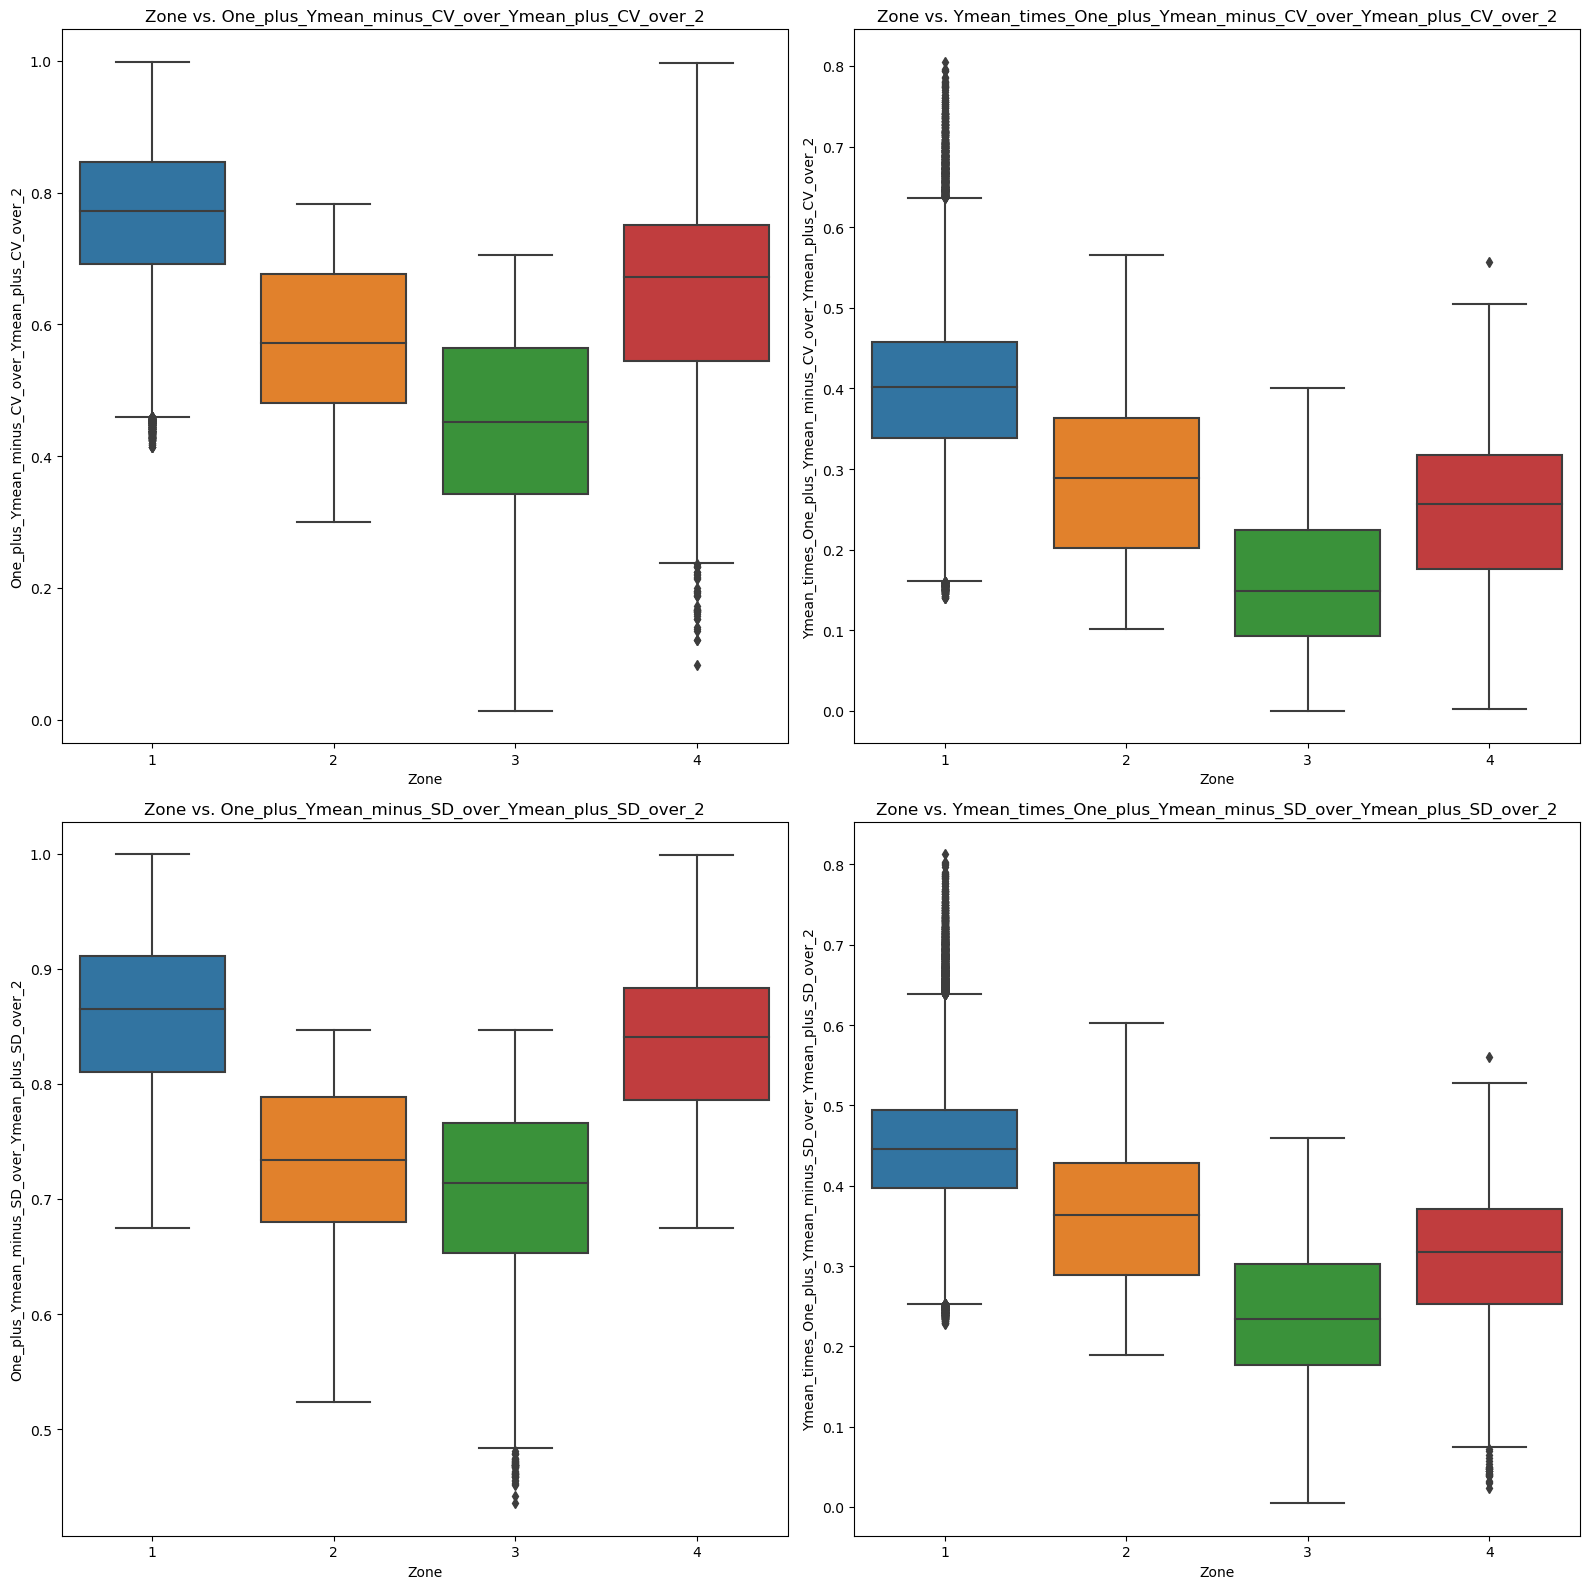

In [9]:
# Set up the matplotlib figure with two subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

# Box plot for Zone vs. One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2
sns.boxplot(x='Zone', y='One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2', data=data, ax=axs[0,0])
axs[0,0].set_title('Zone vs. One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2')
axs[0,0].set_xlabel('Zone')
axs[0,0].set_ylabel('One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2')

# Box plot for Zone vs. Ymean_times_One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2
sns.boxplot(x='Zone', y='Ymean_times_One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2', data=data, ax=axs[0,1])
axs[0,1].set_title('Zone vs. Ymean_times_One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2')
axs[0,1].set_xlabel('Zone')
axs[0,1].set_ylabel('Ymean_times_One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2')

# Box plot for Zone vs. One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2
sns.boxplot(x='Zone', y='One_plus_Ymean_minus_SD_over_Ymean_plus_SD_over_2', data=data, ax=axs[1,0])
axs[1,0].set_title('Zone vs. One_plus_Ymean_minus_SD_over_Ymean_plus_SD_over_2')
axs[1,0].set_xlabel('Zone')
axs[1,0].set_ylabel('One_plus_Ymean_minus_SD_over_Ymean_plus_SD_over_2')

# Box plot for Zone vs. Ymean_times_One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2
sns.boxplot(x='Zone', y='Ymean_times_One_plus_Ymean_minus_SD_over_Ymean_plus_SD_over_2', data=data, ax=axs[1,1])
axs[1,1].set_title('Zone vs. Ymean_times_One_plus_Ymean_minus_SD_over_Ymean_plus_SD_over_2')
axs[1,1].set_xlabel('Zone')
axs[1,1].set_ylabel('Ymean_times_One_plus_Ymean_minus_SD_over_Ymean_plus_SD_over_2')

# Adjust the layout
plt.tight_layout()
plt.show()

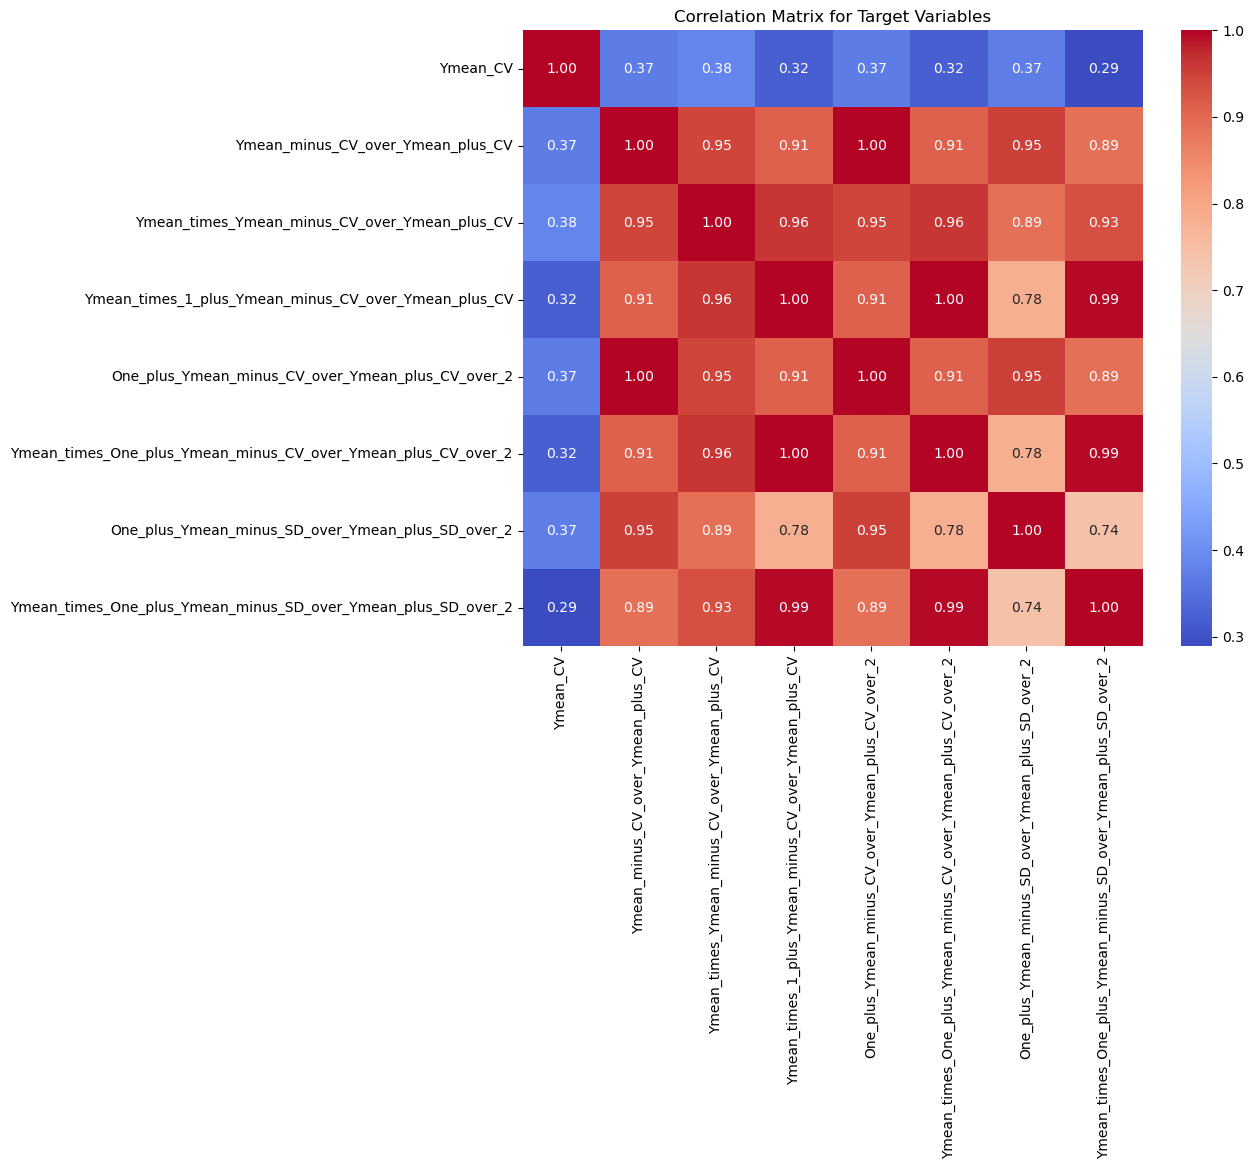

In [10]:
# Define the yield stability indexes (target variables)
target_variables = [
    'Ymean_CV',
    'Ymean_minus_CV_over_Ymean_plus_CV',
    'Ymean_times_Ymean_minus_CV_over_Ymean_plus_CV',
    'Ymean_times_1_plus_Ymean_minus_CV_over_Ymean_plus_CV',
    'One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2',
    'Ymean_times_One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2',
    'One_plus_Ymean_minus_SD_over_Ymean_plus_SD_over_2',
    'Ymean_times_One_plus_Ymean_minus_SD_over_Ymean_plus_SD_over_2'
]

# Calculate the correlation matrix for target variables
corr_matrix_targets = data[target_variables].corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_targets, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Target Variables')
plt.show()

In [13]:
# Define the yield stability indexes and terrain attributes
target_variables = [
    'Ymean_CV',
    'Ymean_minus_CV_over_Ymean_plus_CV',
    'Ymean_times_Ymean_minus_CV_over_Ymean_plus_CV',
    'Ymean_times_1_plus_Ymean_minus_CV_over_Ymean_plus_CV',
    'One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2',
    'Ymean_times_One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2',
    'One_plus_Ymean_minus_SD_over_Ymean_plus_SD_over_2',
    'Ymean_times_One_plus_Ymean_minus_SD_over_Ymean_plus_SD_over_2'
]

# terrain_attributes = [
#     'Aspect', 'Aspect_LP10', 'Aspect_LP30', 'Aspect_ss_5',
#        'DEM5', 'DEM5_ns', 'DEM_ss_5', 'DEM_ss_5_ns', 'FW', 'FW_gs_LP10',
#        'FW_ss_5', 'FlowAccD8', 'FlowAccD8_LP10', 'FlowAccMFD1.1',
#        'FlowAccMFD1.1_LP10', 'FlowAccMFD1.1_ss_5', 'LP10', 'LP10_ns',
#        'LP30', 'MRRTF_LP10', 'MRRTF_ss_5', 'MRVBF_LP10', 'MRVBF_ss_5',
#        'Midslope_LP10', 'NegOpen', 'NegOpen_LP10', 'NegOpen_LP30',
#        'NegOpen_ss_5', 'NormalizedHeight_LP10', 'PosOpen',
#        'PosOpen_LP10', 'PosOpen_LP30', 'PosOpen_ss_5',
#        'ProfileCurvature_LP30', 'SCA_D8_LP10', 'SCA_MFD1.1',
#        'SCA_MFD1.1_LP10', 'SCA_MFD1.1_ss_5', 'SWI10', 'SWI1E16', 'SWI1E2',
#        'SWI1E2_LP10', 'SWI1E2_LP30', 'SWI1E4', 'SWI1E8', 'Slope',
#        'SlopeHeight_LP10', 'Slope_LP10', 'Slope_LP30', 'Slope_ss_5',
#        'StandardizedHeight_LP10', 'TPI_LP10', 'TPI_LP30', 'TPI_ss_5',
#        'TWI_D8_LP10', 'TWI_MFD1.1', 'TWI_MFD1.1_LP10', 'TWI_MFD1.1_ss_5',
#        'TangentCurvature_LP30', 'ValleyDepth_LP10', 'channel_network', 'channel_route', 'geomorphons_LP30',
#        'hillshade', 'vdist_chn_network', 'wind_shelter_LP10',
#        'wind_shelter_ss_5', 'geomorphons_LP10_1', 'geomorphons_LP10_3',
#        'geomorphons_LP10_4', 'geomorphons_LP10_5', 'geomorphons_LP10_6',
#        'geomorphons_LP10_7', 'geomorphons_LP10_8', 'geomorphons_LP10_9',
#     'SoilBulkDensity_0-5cm', 'SoilBulkDensity_100-200cm',
#        'SoilBulkDensity_15-30cm', 'SoilBulkDensity_30-60cm',
#        'SoilBulkDensity_5-15cm', 'SoilBulkDensity_60-100cm',
#        'SoilClay_0-5cm', 'SoilClay_100-200cm', 'SoilClay_15-30cm',
#        'SoilClay_30-60cm', 'SoilClay_5-15cm', 'SoilClay_60-100cm',
#        'SoilSilt_0-5cm', 'SoilSilt_100-200cm', 'SoilSilt_15-30cm',
#        'SoilSilt_30-60cm', 'SoilSilt_5-15cm', 'SoilSilt_60-100cm',
#        'Soil_ksat_0-5cm', 'Soil_ksat_100-200cm', 'Soil_ksat_15-30cm',
#        'Soil_ksat_30-60cm', 'Soil_ksat_5-15cm', 'Soil_ksat_60-100cm',
#        'Soil_om_0-5cm', 'Soil_om_100-200cm', 'Soil_om_15-30cm',
#        'Soil_om_30-60cm', 'Soil_om_5-15cm', 'Soil_om_60-100cm',
#        'SoilpH_0-5cm', 'SoilpH_100-200cm', 'SoilpH_15-30cm',
#        'SoilpH_30-60cm', 'SoilpH_5-15cm', 'SoilpH_60-100cm',
#        'Soilsand_0-5cm', 'Soilsand_100-200cm', 'Soilsand_15-30cm',
#        'Soilsand_30-60cm', 'Soilsand_5-15cm', 'Soilsand_60-100cm',
#     'AnnualPrecipitation', 'PrecipColdestQuarter', 'PrecipDriestMonth', 'PrecipDriestQuarter',
#        'PrecipSeasonality', 'PrecipWarmestQuarter', 'PrecipWettestMonth',
#        'PrecipWettestQuarter', 'MaxTempWarmMonth','MeanTempColdQuarter', 'MeanTempDryQuarter', 'MeanTempWarmQuarter',
#        'MeanTempWetQuarter', 'MinTempColdMonth', 'TempAnnualRange', 'TemperatureSeasonality', 'isothermality',
#        'meanDiurnalRange', 'annualMeanTemperature', 'NDVI_avg'
# ]

terrain_attributes = ['NDVI_avg', 'Soil_om_15-30cm', 'SWI10', 'AnnualPrecipitation', 'NegOpen_LP30', 'PosOpen_LP30', 'ProfileCurvature_LP30', 'TPI_LP30', 
                      'Soil_ksat_30-60cm',  'Slope_LP10', 'Midslope_LP10', 'Aspect_LP30', 'vdist_chn_network', 'StandardizedHeight_LP10', 'TWI_MFD1.1', 
                      'SlopeHeight_LP10', 'TangentCurvature_LP30', 'geomorphons_LP30', 'SoilClay_0-5cm', 'TemperatureSeasonality','ValleyDepth_LP10']


# Store results
results = {}

# Initialize the imputer
imputer = SimpleImputer(strategy='mean')

# Loop through each target variable
for target in target_variables:
    X = data[terrain_attributes]
    y = data[target]

    # Impute missing values
    X = imputer.fit_transform(X)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # Fit the model
    rf.fit(X_train, y_train)

    # Save the model and X_train for future use
    with open(f'models/model_{target}.pkl', 'wb') as model_file:
        pickle.dump(rf, model_file)
    
    pd.DataFrame(X_train).to_csv(f'models/X_train_{target}.csv', index=False)

    # Perform cross-validation
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    mean_cv_score = np.mean(cv_scores)

    # Predict on test set
    y_pred = rf.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)

    # Store feature importances and R² scores
    results[target] = {
        'feature_importances': rf.feature_importances_,
        'cross_val_r2': mean_cv_score,
        'test_r2': test_r2
    }

    print(f'Model for {target}:')
    print(f'Cross-Validation R²: {mean_cv_score}')
    print(f'Test R²: {test_r2}')
    print('Feature Importances:', rf.feature_importances_)
    print()

# Convert results to a DataFrame for easier visualization
importance_df = pd.DataFrame({
    target: results[target]['feature_importances'] for target in target_variables
}, index=terrain_attributes)

r2_scores = pd.DataFrame({
    'Cross_Val_R2': {target: results[target]['cross_val_r2'] for target in target_variables},
    'Test_R2': {target: results[target]['test_r2'] for target in target_variables}
})

Model for Ymean_CV:
Cross-Validation R²: -0.22874468807969545
Test R²: 0.05591143117199948
Feature Importances: [0.07058052 0.0310805  0.07151676 0.00103822 0.04852963 0.07469806
 0.06599314 0.0990169  0.01656525 0.05197236 0.04362075 0.05858502
 0.07170428 0.0629967  0.05951942 0.03484539 0.03240764 0.0025711
 0.02402245 0.00163812 0.0770978 ]

Model for Ymean_minus_CV_over_Ymean_plus_CV:
Cross-Validation R²: 0.8471041056129487
Test R²: 0.8544875638504249
Feature Importances: [0.37316702 0.01580533 0.03579391 0.04453588 0.02879343 0.05121398
 0.02643322 0.03407928 0.0598047  0.02157301 0.01767559 0.03916917
 0.03263244 0.0632397  0.02682758 0.02070354 0.02603401 0.00413562
 0.04078827 0.01278936 0.02480496]

Model for Ymean_times_Ymean_minus_CV_over_Ymean_plus_CV:
Cross-Validation R²: 0.859377240943552
Test R²: 0.8678676803197302
Feature Importances: [0.37405833 0.02555837 0.0319618  0.0844722  0.02738984 0.0340927
 0.03193851 0.03039833 0.08575313 0.02965796 0.01731943 0.03669524
 0.

In [14]:
# Save the results to CSV files
importance_df.to_csv('feature_importances_3.csv')
r2_scores.to_csv('r2_scores_3.csv')

print('Feature importances and R² scores saved to CSV files.')

Feature importances and R² scores saved to CSV files.


In [16]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

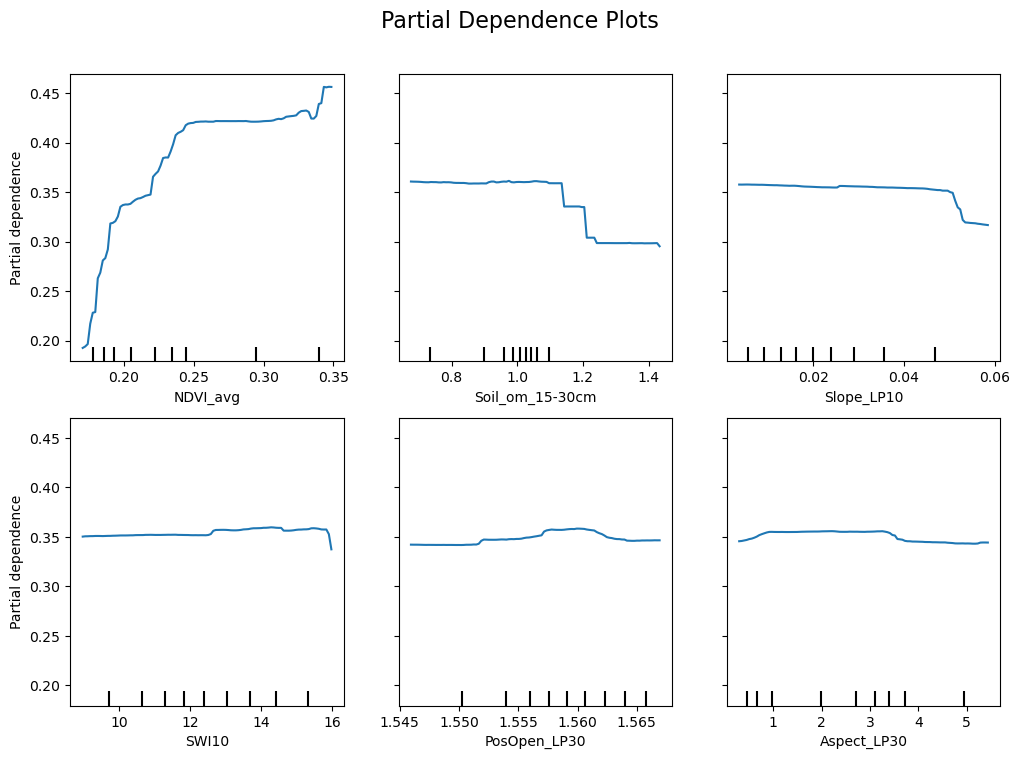

In [17]:
# Define the variables for partial dependence plots
pdp_variables = ['NDVI_avg', 'Soil_om_15-30cm', 'Slope_LP10', 'SWI10', 'PosOpen_LP30', 'Aspect_LP30']

# Plot partial dependence plots for each variable
fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(rf, X_train, pdp_variables, feature_names=terrain_attributes, ax=ax)
plt.suptitle('Partial Dependence Plots', fontsize=16)
plt.subplots_adjust(top=0.9)  # Adjust top to accommodate title
plt.show()

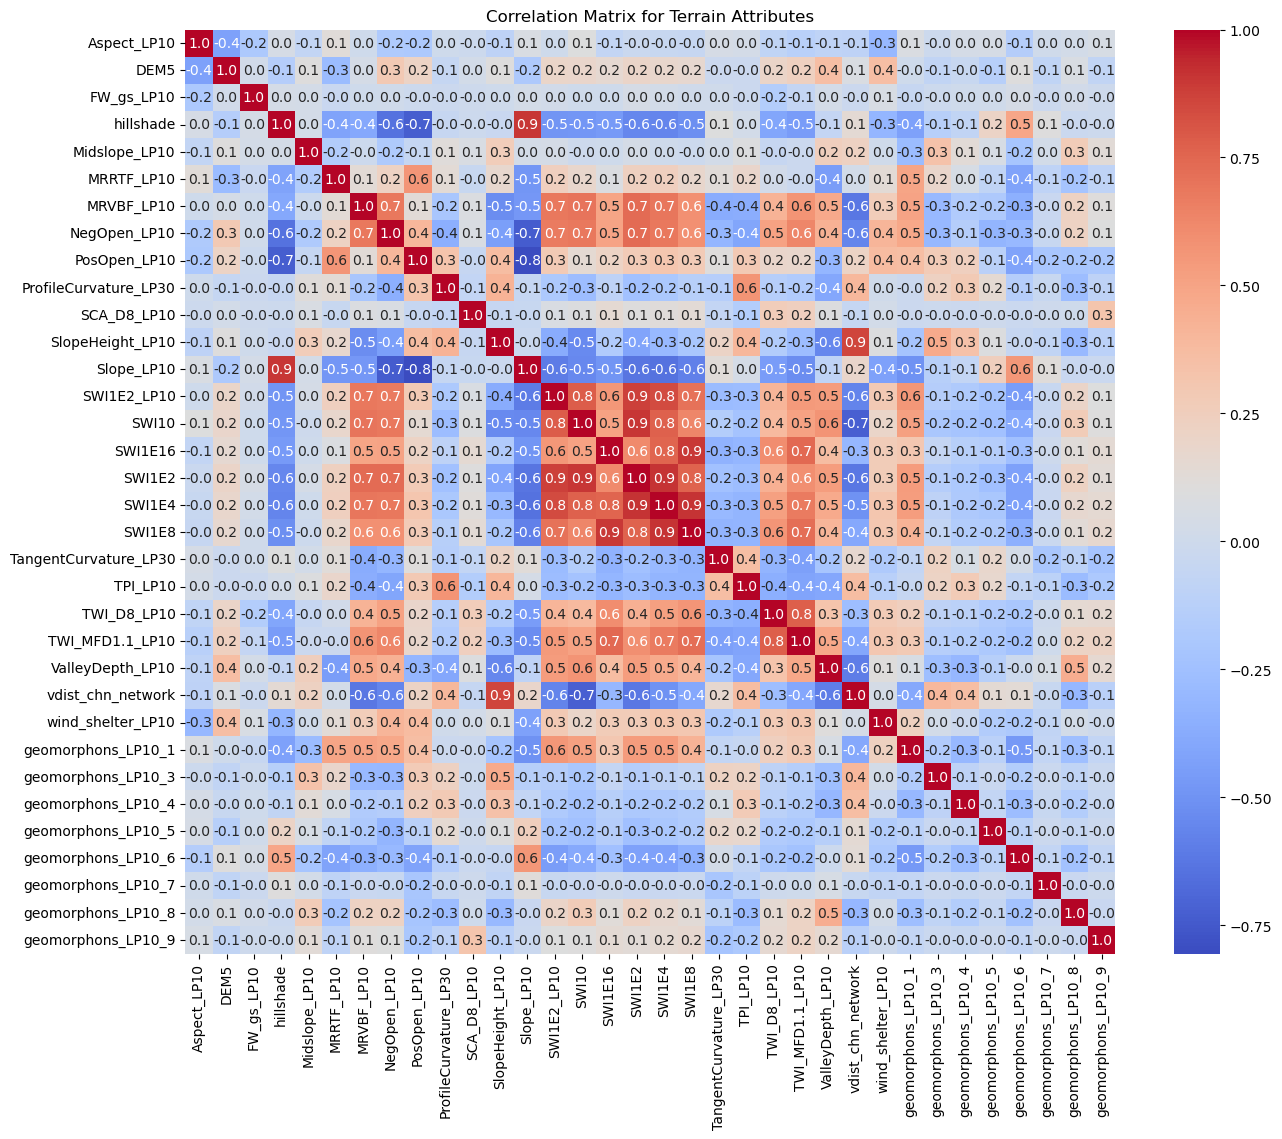

In [15]:
# Define the terrain attributes
terrain_attributes = [
    'Aspect_LP10', 'DEM5', 'FW_gs_LP10',
    'hillshade', 'Midslope_LP10', 'MRRTF_LP10', 'MRVBF_LP10', 'NegOpen_LP10', 'PosOpen_LP10',
    'ProfileCurvature_LP30', 'SCA_D8_LP10', 'SlopeHeight_LP10', 'Slope_LP10','SWI1E2_LP10', 
    'SWI10', 'SWI1E16', 'SWI1E2', 'SWI1E4', 'SWI1E8', 'TangentCurvature_LP30', 
    'TPI_LP10', 'TWI_D8_LP10', 'TWI_MFD1.1_LP10', 'ValleyDepth_LP10', 'vdist_chn_network', 'wind_shelter_LP10',
     'geomorphons_LP10_1', 'geomorphons_LP10_3', 'geomorphons_LP10_4', 'geomorphons_LP10_5', 'geomorphons_LP10_6',
       'geomorphons_LP10_7', 'geomorphons_LP10_8', 'geomorphons_LP10_9'
]

# Calculate the correlation matrix for terrain attributes
corr_matrix_terrain = data[terrain_attributes].corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix_terrain, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation Matrix for Terrain Attributes')
plt.show()

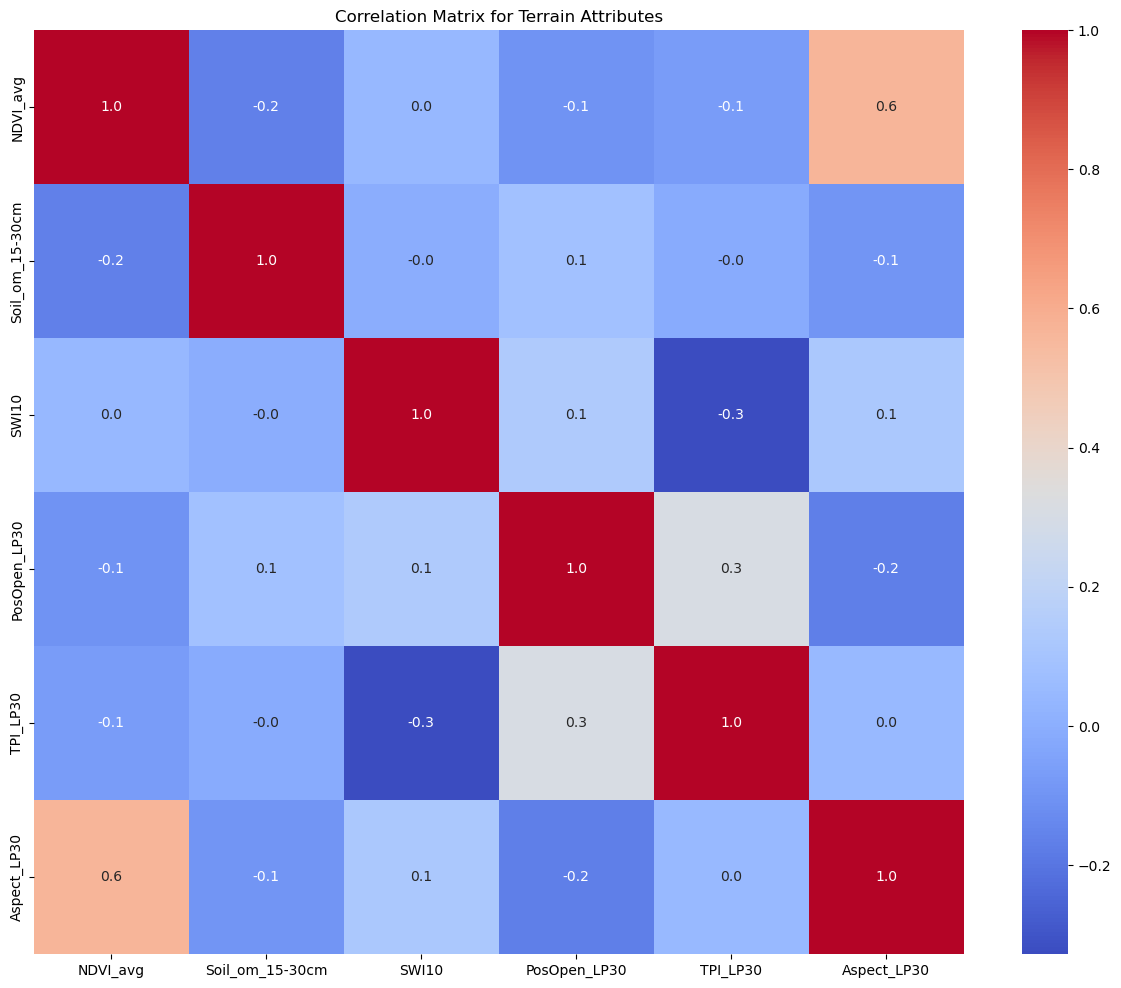

In [4]:
# Define the terrain attributes
terrain_attributes = ['NDVI_avg',
 'Soil_om_15-30cm',
 'SWI10',
 'PosOpen_LP30',
 'TPI_LP30',
 'Aspect_LP30']

# Calculate the correlation matrix for terrain attributes
corr_matrix_terrain = data[terrain_attributes].corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix_terrain, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation Matrix for Terrain Attributes')
plt.show()